## PROBLEM SET 1 - TAKE AT HOME (25 POINTS)

**You will lose all corresponding points if we can't access the implementation notebook URL or the Github URL. We will NOT message you. Do NOT invite the TAs to your Github repo (option 2 below) EARLIER than the morning of the day of the exam, since invites expire in 7 days.**

## Introduction

In the last few years, the field of generative modeling has seen a lot of progress. The techniques that have been developed in this field are very useful for other tasks such as semi-supervised learning, representation learning, and reinforcement learning. In this problem statement we attempt to prepare you to understand the basics of a technique that has been very successful in generative modeling: Variational Autoencoders (VAEs). Understanding VAEs is  the key for you to get a head start with more advanced models such as [Stable Diffusion that are all the rage these days](https://clipdrop.co/stable-diffusion-turbo).



## Task 1: Study what VAEs are and how they work (0 points)

Consult this [blog post](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) and its [2D VAE autoencoder implemenation for the MNIST dataset](https://github.com/jaanli/variational-autoencoder).

## Task 2: Replicate the VAE for the MNIST dataset (25 points)

Implement the VAE model for the MNIST dataset and train it ensuring that you plot the loss curves for the training and validation sets and perform hyperparameter optimization on the size of the latent space as well as on the optimizer parameters. To all points you need to include as comments in the code or as markdown cells what each function in the code is doing. Don't be frugal in your commentary. (15 points)

Replicate the figure showing the final latent variable space shown below. Note that you will not produce the animated figure shown below but show only the final latent space $(z_1, z_2)$. (5 points)

Show VAE generated images for all digits 0-9 after model training. (5 points)

![](latent-variables.gif)

You have two implementation options: (1) All in one notebook (2) Github repo.

### Option 1: All in one Colab notebook

You submit a single Colab notebook URL that contains all the code and the outputs. Your notebook should be self-contained and can be launched in Google Colab using a corresponding button at the top of the notebook. See the regression notebook in the course site for an example of such button. You **need to save all outputs in the notebook** so that the TAs can check that your code is working properly.

### Option 2: Github repo

If you prefer to work without notebooks, with containers or not, you can submit the implementation python scripts and version control your code in a private Github repo. You have to submit the Github URL and clearly document the way to launch the runtime / install requirements.txt and include all required figures in the README.md file.

IMPORTANT: Ensure that the github repo remains private. If you submit a public github repo you will be held responsible for violating the honor code.

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
gpuDeviceValue = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpuDeviceValue

device(type='cuda', index=0)

In [3]:
vaeBatchSize = 500 #the number of images to use for a SGD update
vaeSamplesPerDataPoint = 3 #Samples per data point.
numHiddenEncoder = 1000 #number of hidden units in the encoder
numHiddenDecoder = 1000 #number of hidden units in the decoder
numLatentDimensions = 4 #number of latent dimensions
numLearningRate = 0.005 #learning rate for SGD
weightDecayRate = 1e-8 #weight decay for SGD
numEpochs = 20 #number of times the programs loops through the entire dataset, or an epoch


In [4]:
#Transformation for 0-1 scaling only. Cannot normalize with VAE since VAE has mean 0 and standard deviation 1.
#normalizing will yield negative pixel value
tensorLoopTransformation = transforms.Compose([transforms.ToTensor()])

#Using the tensorLoopTransformation for both training and testing set
mnistVAETrainingDataset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = tensorLoopTransformation)
mnistVAETestingDataset = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = tensorLoopTransformation)

#Loading the training and test set
mnistVAETrainLoader = DataLoader(mnistVAETrainingDataset, batch_size = vaeBatchSize, shuffle = True)
mnistVAETestLoader = DataLoader(mnistVAETestingDataset, batch_size = vaeBatchSize, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 83789563.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32140008.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71466569.50it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20774840.53it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class vaeEncoderMethod(nn.Module):
  def __init__(self):
    super(vaeEncoderMethod, self).__init__()
    # We are defining the Fully-Connected FeedForward Network with its input features and output features.
    self.hidden = nn.Linear(in_features=28*28, out_features=numHiddenEncoder)
    # There are two separate layers: muLayerValue and logVarianceLayerValue that are involved in a FeedForward Network.
    self.muLayerValue     = nn.Linear(in_features=numHiddenEncoder, out_features=numLatentDimensions)
    self.logVarianceLayerValue = nn.Linear(in_features=numHiddenEncoder, out_features=numLatentDimensions)

  def forward(self, inputvaeLayer):
    # The inputvaeLayer is passed through the first set of connections.
    inputvaeLayer = F.relu(self.hidden(inputvaeLayer))
    # One set of connections retrieves muLayerValue and the other retrieves logVarianceLayerValue.
    return self.muLayerValue(inputvaeLayer), self.logVarianceLayerValue(inputvaeLayer)

In [6]:
class vaeDecoderMethod(nn.Module):
  def __init__(self):
    super(vaeDecoderMethod, self).__init__()
    # We are defining the Fully-Connected FeedForward Network with its input features and output features.
    self.hidden = nn.Linear(in_features=numLatentDimensions, out_features=numHiddenDecoder)
    # The output_layer is passed through the second set of connections with the inut features and the output features defined accordingly.
    self.output_layer = nn.Linear(in_features=numHiddenDecoder, out_features=28*28)

  def forward(self, restrictedSigmoidFunction):
    # A sigmoid function is used to limit output values at the end between 0 and 1 for interpreting them as probabilities.
    restrictedSigmoidFunction = F.relu(self.hidden(restrictedSigmoidFunction))
    return torch.sigmoid(self.output_layer(restrictedSigmoidFunction))

In [7]:
class variationalAutoEncoder(nn.Module):
  def __init__(self):
    super(variationalAutoEncoder, self).__init__()
    self.encoder = vaeEncoderMethod()
    self.decoder = vaeDecoderMethod()

  def vaeLatentSampling(self, muLayerValue, logVarianceLayerValue):
    if self.training:
      # Retrieving vaeStandardNormal with the torch library in the feature of muLayerValue
      vaeStandardNormal = torch.randn_like(muLayerValue)
      # logVariance is transformed to vaeStandardNormal and multiplied to muLayerValue
      return vaeStandardNormal.mul(torch.exp(0.5*logVarianceLayerValue)).add_(muLayerValue)
      #output muLayerValue to the user
      return muLayerValue

  def forward(self, inputvaeLayer):
    # The resultant image is fed to the encoder muLatentValue and logVarianceLatentValue is fed to the input.
    muLatentValue, logVarianceLatentValue = self.encoder(inputvaeLayer.view(-1, 28*28))
    # use restricted sigmoid function with a vaeLatentSampling having muLatentValue and logVarianceLatentValue as parameters
    restrictedSigmoidFunction = self.vaeLatentSampling(muLatentValue, logVarianceLatentValue)
    # The decoder decodes the latent representation of the restrictedSigmoidFunction and muLatentValue and logVarianceLatentValue as parameters
    return self.decoder(restrictedSigmoidFunction), muLatentValue, logVarianceLatentValue

In [8]:
def variationEncoderLoss(variationEncoderImage, variationEncoderReconstructionValue, muLayerValue, logVarianceLayerValue):
  # The cross entropy, or the loss function for the Variational AutoEncoder is calculated with the variationEncoderLoss function
  variationEncoderReconstructionLoss = F.binary_cross_entropy(input=variationEncoderReconstructionValue.view(-1, 28*28), target=variationEncoderImage.view(-1, 28*28), reduction='sum')
  # KL Divergence is calculated using the formula shown below
  klDivergence = 0.5 * torch.sum(1 + logVarianceLayerValue - muLayerValue.pow(2) - logVarianceLayerValue.exp())
  #output variationEncoderReconstructionLoss - klDivergence to the user
  return variationEncoderReconstructionLoss - klDivergence

In [9]:
# Instantiating the Variational AutoEncoder
variationalAutoEncoderValue = variationalAutoEncoder()

# Passing the VAE to the GPU
variationalAutoEncoderValue = variationalAutoEncoderValue.to(gpuDeviceValue)

# The SGD or Stochastic Gradient Descent is used as the viable optimizer
variationalEncoderOptimizer = optim.Adam(params=variationalAutoEncoderValue.parameters(), lr=numLearningRate, weight_decay=weightDecayRate)

# The VAE is trained with the parameters and optimization specified in the SGD as the optimizer
variationalAutoEncoderValue.train()

variationalAutoEncoder(
  (encoder): vaeEncoderMethod(
    (hidden): Linear(in_features=784, out_features=1000, bias=True)
    (muLayerValue): Linear(in_features=1000, out_features=4, bias=True)
    (logVarianceLayerValue): Linear(in_features=1000, out_features=4, bias=True)
  )
  (decoder): vaeDecoderMethod(
    (hidden): Linear(in_features=4, out_features=1000, bias=True)
    (output_layer): Linear(in_features=1000, out_features=784, bias=True)
  )
)

In [10]:
# variationAutoEncoderLosses array stores all the losses for the cross entropy
variationAutoEncoderLosses = []

for vaeEpochValue in range(numEpochs):
  variationAutoEncoderLosses.append(0)

  # computing the number of variationalNumBatches and initializing it to 0
  variationalNumBatches = 0

  for variationalImages, _ in mnistVAETrainLoader:
    variationalImages = variationalImages.to(gpuDeviceValue)
    #Setting previous gradients to 0 in the variationalEncoderOptimizer
    variationalEncoderOptimizer.zero_grad()

    # The images are fed through VAE and their respective losses are calculated
    variationEncoderReconstructionValues, muLatentValue, logVarianceLatentValue = variationalAutoEncoderValue(variationalImages)

    # The reconstruction and image values are compared using the variationEncoderLoss function
    variationalAutoEncoderLossValue = variationEncoderLoss(variationalImages, variationEncoderReconstructionValues, muLatentValue, logVarianceLatentValue)

    #Backpropagation of the loss function
    variationalAutoEncoderLossValue.backward()

    # Step into the function for the optimizer
    variationalEncoderOptimizer.step()

    # Adding loss to the respective addition of the losses
    variationAutoEncoderLosses[-1] += variationalAutoEncoderLossValue.item()
    variationalNumBatches += 1

  # Dividing total loss for this epoch by the number of epochs yields the average net loss for the batch
  variationAutoEncoderLosses[-1] /= variationalNumBatches
  print('Following epoch number [%d / %d] Mean Reconstruction Error Value: %f' % (vaeEpochValue+1, numEpochs, variationAutoEncoderLosses[-1]))

Following epoch number [1 / 20] Mean Reconstruction Error Value: 88566.904036
Following epoch number [2 / 20] Mean Reconstruction Error Value: 71489.312174
Following epoch number [3 / 20] Mean Reconstruction Error Value: 69075.869759
Following epoch number [4 / 20] Mean Reconstruction Error Value: 67879.513216
Following epoch number [5 / 20] Mean Reconstruction Error Value: 67114.834115
Following epoch number [6 / 20] Mean Reconstruction Error Value: 66505.101204
Following epoch number [7 / 20] Mean Reconstruction Error Value: 66032.578027
Following epoch number [8 / 20] Mean Reconstruction Error Value: 65749.684831
Following epoch number [9 / 20] Mean Reconstruction Error Value: 65393.393587
Following epoch number [10 / 20] Mean Reconstruction Error Value: 65143.580241
Following epoch number [11 / 20] Mean Reconstruction Error Value: 64922.429069
Following epoch number [12 / 20] Mean Reconstruction Error Value: 64694.866146
Following epoch number [13 / 20] Mean Reconstruction Error Va

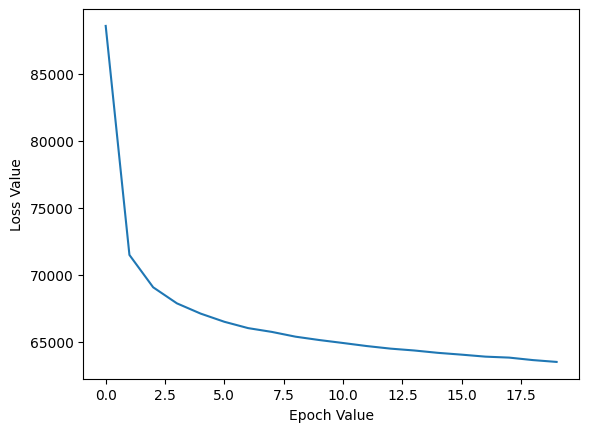

In [11]:
fig = plt.figure()
plt.plot(variationAutoEncoderLosses)
plt.xlabel('Epoch Value')
plt.ylabel('Loss Value')
plt.show()

In [27]:
# vae is established to evaluation mode with the eval function
variationalAutoEncoderValue.eval()

# Storing the testing loss of the vae and the number of batches
variationalEncoderTestingLoss, vaeNumberBatches = 0.0, 0

for vaeTestImages, _ in mnistVAETestLoader:

  # Ignoring the gradients in the tracking
  with torch.no_grad():

    # Sending vaeTestImages to the GPU
    vaeTestImages = vaeTestImages.to(gpuDeviceValue)

    # Images are fed through the VAE to represent as latent factors
    # variationEncoderReconstructionValues, muLatentValue, logVarianceLatentValue = variationalAutoEncoderValue(vaeTestImages)

    # Reconstruction loss value is calculated
    vaeLoss = variationEncoderLoss(vaeTestImages, variationEncoderReconstructionValues, muLatentValue, logVarianceLatentValue)

    # Finding the total loss and number of batches
    variationalEncoderTestingLoss += vaeLoss.item()
    vaeNumberBatches += 1

# Obtaining the average loss per batch
variationalEncoderTestingLoss /= vaeNumberBatches
print('Mean Reconstruction Error Value: %f' % (variationalEncoderTestingLoss))



Mean Reconstruction Error Value: 217527.224219


Source Image View


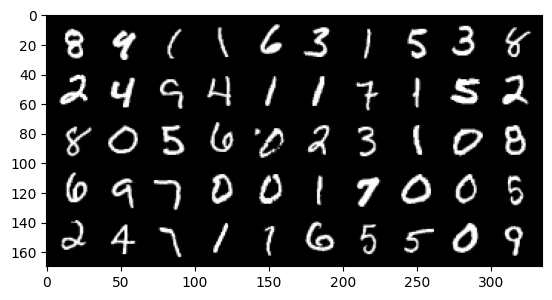

In [28]:
# Utilizing the reconstructions to observe the visual of the handwritten digits in the MNIST using VAE
with torch.no_grad():
  print("Source Image View")
  vaeTestImages = vaeTestImages.cpu()
  vaeTestImages = vaeTestImages.clamp(0, 1)
  vaeTestImages = vaeTestImages[:50]
  vaeTestImages = make_grid(vaeTestImages, 10, 5)
  vaeTestImages = vaeTestImages.numpy()
  vaeTestImages = np.transpose(vaeTestImages, (1, 2, 0))
  plt.imshow(vaeTestImages)

Reconstruction Generated Value


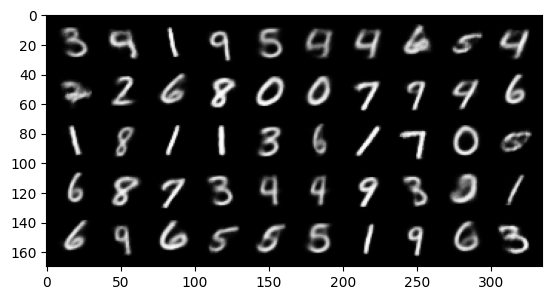

In [29]:
with torch.no_grad():
  print("Reconstruction Generated Value")
  variationEncoderReconstructionValue = variationEncoderReconstructionValues.view(variationEncoderReconstructionValues.size(0), 1, 28, 28)
  variationEncoderReconstructionValue = variationEncoderReconstructionValue.cpu()
  variationEncoderReconstructionValue = variationEncoderReconstructionValue.clamp(0, 1)
  variationEncoderReconstructionValue = variationEncoderReconstructionValue[:50]
  plt.imshow(np.transpose(make_grid(variationEncoderReconstructionValue, 10, 5).numpy(), (1, 2, 0)))

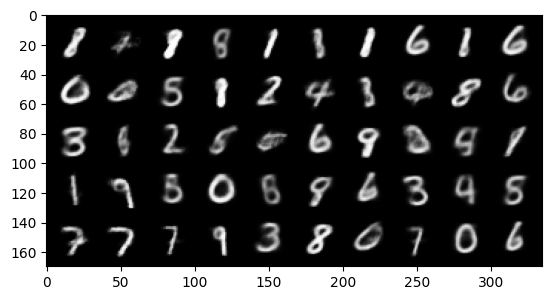

In [30]:
variationalAutoEncoderValue.eval()
with torch.no_grad():
  # Utilizing a standard normal distribution
  restrictedSigmoidFunction = torch.randn(50, numLatentDimensions, device=gpuDeviceValue)

  # Sampling latent vectors and reconstructing an image from them
  vaeReconstructedImages = variationalAutoEncoderValue.decoder(restrictedSigmoidFunction)
  vaeReconstructedImages = vaeReconstructedImages.view(vaeReconstructedImages.size(0), 1, 28, 28)
  vaeReconstructedImages = vaeReconstructedImages.cpu()
  vaeReconstructedImages = vaeReconstructedImages.clamp(0, 1)

  # Plotting the respective images
  plt.imshow(np.transpose(make_grid(vaeReconstructedImages, 10, 5).numpy(), (1, 2, 0)))

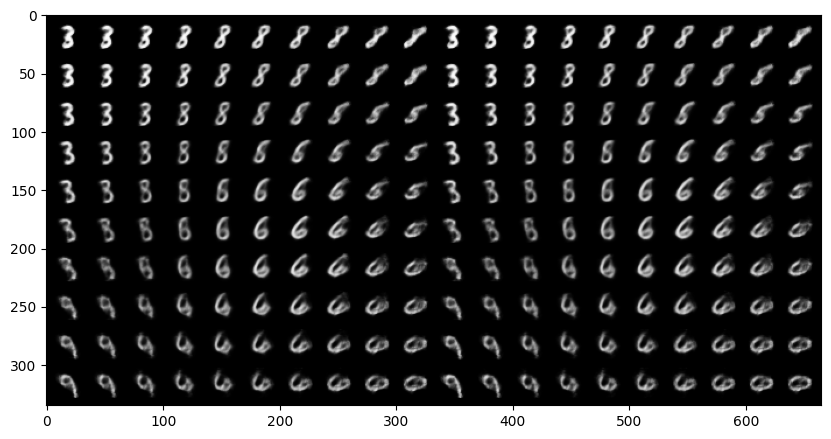

In [31]:
with torch.no_grad():
  # Blank x, y grid with the latentxDimension and latentyDimension
  vaeLatentVariablexDimension = np.linspace(-1.5, 1.5, 20)
  vaeLatentVariableyDimension = np.linspace(-1.5, 1.5, 20)
  vaeLatentVariable = torch.FloatTensor(len(vaeLatentVariablexDimension), len(vaeLatentVariableyDimension), 2)
  # Populating the blank x, y grid with the latentXDimension and latentYDimension
  for w, klatentXDimension in enumerate(vaeLatentVariablexDimension):
    for q, klatentYDimension in enumerate(vaeLatentVariableyDimension):
      vaeLatentVariable[q, w, 0] = klatentXDimension
      vaeLatentVariable[q, w, 1] = klatentYDimension
  # Flattening the vaeLatentVariable grid
  vaeLatentVariable = vaeLatentVariable.view(-1, 4)
  # Sending vaeLatentVariable to the gpuDeviceValue
  vaeLatentVariable = vaeLatentVariable.to(gpuDeviceValue)
  # Finding the variationEncoderReconstructionValue
  variationEncoderReconstructionValue = variationalAutoEncoderValue.decoder(vaeLatentVariable).reshape(-1, 1, 28,28)
  variationEncoderReconstructionValue = variationEncoderReconstructionValue.cpu()
  # Plotting the respective Variational AutoEncoder Handwritten Digit Function as a Plot
  fig, ax = plt.subplots(figsize=(10, 10))
  plt.imshow(np.transpose(make_grid(variationEncoderReconstructionValue.data[:400], 20, 5).clamp(0, 1).numpy(), (1, 2, 0)))
